<a href="https://colab.research.google.com/github/the-ml-bull/Hello_World/blob/main/03_Understanding_LG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
# IMPORT DATA From github 
#

import pandas as pd 
from datetime import datetime 

url = 'https://raw.githubusercontent.com/the-ml-bull/Hello_World/main/Fx60.csv'
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

df = pd.read_csv(url, parse_dates=['date'], date_parser=dateparse)

df.head(n=10)

In [3]:
#
# Create time shifted data as basis for model 
#

import numpy as np

df = df[['date', 'audusd_open', 'audusd_close']].copy()

# x is the last 4 values so create x for each 
#df['x_t-4'] = df['audusd_close'].shift(4)
#df['x_t-3'] = df['audusd_close'].shift(3)
df['x_t-2'] = df['audusd_close'].shift(2)
df['x_t-1'] = df['audusd_close'].shift(1)

# y is points 4 periods into the future - the open price now (not close)
df['y_future'] = df['audusd_close'].shift(-3)
df['y_change_price'] = df['y_future'] - df['audusd_open']
df['y_change_points'] = df['y_change_price'] * 100000 
df['y'] = np.where(df['y_change_points'] >= 200, 1, 0)

In [4]:
#
# Create Train and Val datasets 
#
from sklearn.linear_model import LogisticRegression   

#x = df[['x_t-4', 'x_t-3', 'x_t-2', 'x_t-1']]
x = df[['x_t-2', 'x_t-1']]
y = df['y']
y_points = df['y_change_points']   # we will use this later    

# Note Fx "follows" (time series) so randomization is NOT a good idea
# create train and val datasets. 
no_train_samples = int(len(x) * 0.7)
x_train = x[4:no_train_samples]
y_train = y[4:no_train_samples]
y_train_change_points = y_points[4:no_train_samples]

x_val = x[no_train_samples:-3]
y_val = y[no_train_samples:-3]
y_val_change_points = y_points[no_train_samples:-3]

In [5]:
#
# Create class weights 
#
from sklearn.utils.class_weight import compute_class_weight

num_ones = np.sum(y_train)
num_zeros = len(y_train) - num_ones 
print('In the training set we have 0s {} ({:.2f}%), 1s {} ({:.2f}%)'.format(num_zeros, num_zeros/len(df)*100, num_ones, num_ones/len(df)*100))

classes = np.unique(y_train)
class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weight))

print('class weights {}'.format(class_weight))

In the training set we have 0s 31608 (62.55%), 1s 3761 (7.44%)
class weights {0: 0.5594944317894204, 1: 4.702073916511566}


In [6]:
#
# fit the model (step by step)
#

def sigmoid(x):
  return 1 / (1 + np.exp(-x))


lr = LogisticRegression(class_weight=class_weight, warm_start=True)

start_ix=0
increments=500
x_list, y_list = [], []
while start_ix < (len(x_train) - increments):

  x = x_train.iloc[start_ix:start_ix+increments].to_numpy()
  y = y_train.iloc[start_ix: start_ix+increments].to_numpy() 

  lr.fit(x, y)

  intercept = float(lr.intercept_)
  coef_x1 = float(lr.coef_[0, 0])
  coef_x2 = float(lr.coef_[0, 1])
  x1 = float(x[-1, 0])
  x2 = float(x[-1, 1])

  predicted = float(lr.predict_proba(x[-1].reshape(1, 2))[0, 1])
  calculated = intercept + (coef_x1 * x1) + (coef_x2 * x2)

  print('ix: {}, x1: {:.5f}, x2: {:.5f}, y: {} int: {:.5f}, w1: {:.5f}, w2: {:.5f}, Calc: {:.5f}, CalSig: {:.5f}, Pred: {:.5f}'.format(start_ix+100, 
    x[0,0], x[0, 1], y[0],
    intercept, coef_x1, coef_x2, 
    calculated, sigmoid(calculated), predicted))  

  start_ix += increments

ix: 100, x1: 0.81303, x2: 0.81182, y: 0 int: 0.45227, w1: 0.15363, w2: 0.11073, Calc: 0.65809, CalSig: 0.65883, Pred: 0.65883
ix: 600, x1: 0.77916, x2: 0.77877, y: 0 int: 1.33115, w1: -0.45696, w2: -0.44997, Calc: 0.62640, CalSig: 0.65167, Pred: 0.65167
ix: 1100, x1: 0.77728, x2: 0.78079, y: 0 int: 1.12142, w1: -0.40329, w2: -0.36473, Calc: 0.53716, CalSig: 0.63115, Pred: 0.63115
ix: 1600, x1: 0.76105, x2: 0.76194, y: 0 int: 0.84557, w1: -0.01806, w2: 0.01031, Calc: 0.83932, CalSig: 0.69832, Pred: 0.69832
ix: 2100, x1: 0.80537, x2: 0.80359, y: 0 int: -0.16514, w1: 0.20014, w2: 0.20434, Calc: 0.14348, CalSig: 0.53581, Pred: 0.53581
ix: 2600, x1: 0.76230, x2: 0.76381, y: 0 int: 0.82224, w1: -0.24123, w2: -0.23443, Calc: 0.45607, CalSig: 0.61208, Pred: 0.61208
ix: 3100, x1: 0.76899, x2: 0.76910, y: 0 int: 0.31665, w1: -0.06165, w2: -0.12989, Calc: 0.17706, CalSig: 0.54415, Pred: 0.54415
ix: 3600, x1: 0.72898, x2: 0.72794, y: 0 int: 0.83133, w1: -0.39942, w2: -0.37765, Calc: 0.27199, CalSi

In [9]:
# Retrieve the model parameters.

def fit_and_get_parameters(x, y, class_weight):

  lr = LogisticRegression(class_weight=class_weight)
  lr.fit(x, y)

  b = float(lr.intercept_[0])
  w1, w2 = lr.coef_.T
  w1 = float(w1)
  w2 = float(w2)

  # Calculate the intercept and gradient of the decision boundary.
  c = float(-b/w2)
  m = float(-w1/w2)

  # get the min / max values of x1 and use to find decision boundary wtih x2 
  min_x1_value = x['x_t-1'].min()
  max_x1_value = x['x_t-1'].max()
  x1_values = np.array([min_x1_value, max_x1_value])
  x2_values = -w1/w2 * x1_values - (b / w2)

  print('y = {:.2f} + {:.2f} x1 + {:.2f} x2 Intercept(c): {:.2f}, Gradient(m): {:.3f} x1: {}, x2: {}'.format(b, w1, w2, c, m, x1_values, x2_values))

  return x1_values, x2_values



In [8]:
#
# chart the points and decision boundary
#
import matplotlib.pyplot as plt

def plot_decision_boundary(x, y, x1_values, x2_values, heading):
  
  # put 0's and 1's in two seperate lists for display 
  list_0_x1, list_0_x2, list_1_x1, list_1_x2 = [], [], [], []
  for ix in range(len(y)):
    if y.iloc[ix] == 0:
      list_0_x1.append(x['x_t-1'].iloc[ix])
      list_0_x2.append(x['x_t-2'].iloc[ix])
    else:
      list_1_x1.append(x['x_t-1'].iloc[ix])
      list_1_x2.append(x['x_t-2'].iloc[ix])

  # scaterplot the 0's and 1's
  plt.scatter(list_0_x1, list_0_x2, marker='o', color='blue')
  plt.scatter(list_1_x1, list_1_x2, marker='x', color='red')

  # Draw the decision boundary 
  plt.plot(x1_values, x2_values, linestyle='-', color='black')

  # axis labels 
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title(heading)
  
  return 

y = 0.32 + -0.20 x1 + -0.23 x2 Intercept(c): 1.37, Gradient(m): -0.874 x1: [0.55519 0.82848], x2: [0.88765465 0.64877731]


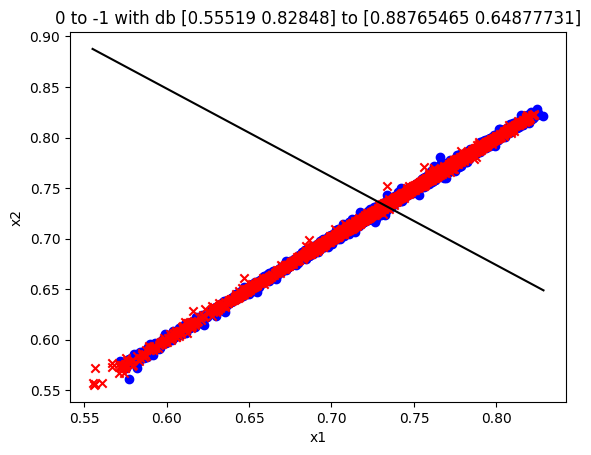

In [12]:
start_ix, stop_ix = 0, -1
x1_values, x2_values = fit_and_get_parameters(x_train.iloc[start_ix:stop_ix], y_train.iloc[start_ix:stop_ix], class_weight)
plot_decision_boundary(x_train.iloc[start_ix:stop_ix], y_train.iloc[start_ix:stop_ix], x1_values, x2_values, '{} to {} with db {} to {}'.format(start_ix, stop_ix, x1_values, x2_values))
